In [4]:
#https://github.com/Danjtchen/LSTM_stock_example
#https://medium.com/data-scientists-playground/lstm-%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92-%E8%82%A1%E5%83%B9%E9%A0%90%E6%B8%AC-cd72af64413a

In [14]:
datestest = pd.date_range('20130101', periods=6)
dftest = pd.DataFrame(np.arange(24).reshape((6,4)),index=datestest, columns=['A','B','C','D'])


In [15]:
dftest

,A,B,C,D
2013-01-01,0,1,2,3
2013-01-02,4,5,6,7
2013-01-03,8,9,10,11
2013-01-04,12,13,14,15
2013-01-05,16,17,18,19
2013-01-06,20,21,22,23


In [30]:
print(dftest.iloc[0:6,0:-1])

             A   B   C
2013-01-01   0   1   2
2013-01-02   4   5   6
2013-01-03   8   9  10
2013-01-04  12  13  14
2013-01-05  16  17  18
2013-01-06  20  21  22


In [1]:
#coding=utf-8
import pandas as pd
import numpy as np

#from math import sqrt
from keras.models import Sequential,Model
#讓層彼此線性(相互)交疊
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint 
#MCP to save the model
import matplotlib.pyplot as plt
from keras.utils import to_categorical
#將向量轉換為二進制矩陣
%matplotlib inline
#%matplotlib inline 可以在Ipython编译器里直接使用，功能是可以内嵌绘图，并且可以省略掉plt.show()这一步。

Using TensorFlow backend.


In [2]:
train = pd.read_csv('/home/raman/Downloads/sanyi data.csv') 
#train = pd.read_csv('/home/raman/Downloads/st.csv') 
#do not use the 'r' , it will cause the key error 'close', it should be a type error.
train.head()


,SiteName,PublishTime,PM25,O3,SO2,CO
0,Sanyi,2018/1/1 00:00,16.0,39.0,2.6,0.28
1,Sanyi,2018/1/1 01:00,21.0,40.0,2.3,0.26
2,Sanyi,2018/1/1 02:00,22.0,40.0,0.8,0.28
3,Sanyi,2018/1/1 03:00,19.0,40.0,0.9,0.27
4,Sanyi,2018/1/1 04:00,22.0,40.0,0.7,0.26


In [3]:
def normalize(df):
    norm = df.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return norm
def train_windows(df, ref_day=20, predict_day=1):
    X_train, Y_train = [], []
    for i in range(df.shape[0]-predict_day-ref_day):
        X_train.append(np.array(df.iloc[i:i+ref_day,:-1])) #倒數一行除外
        Y_train.append(np.array(df.iloc[i+ref_day:i+ref_day+predict_day]["y"]))
        #iloc用法
        #https://morvanzhou.github.io/tutorials/data-manipulation/np-pd/3-2-pd-indexing/ 
        #--------------------------------------------------------------------------------------------------       
        #选取标签为A和C的列，并且选完类型还是dataframe df.iloc 指定行數 EX: df = df.iloc[:, [0, 2]]
        #"，"前面的"："表示选取整列，第二个示例中的的0:2表示选取第0行到第二行，这里的0:2相当于[0,2）前闭后开，2是不在范围之内的。
        #需要注意的是，如果是df = df.loc[0:2, ['A', 'C']]或者df = df.loc[0:2, ['A', 'C']]，切片之后类型依旧是dataframe，不能直接进行
        #--------------------- 
        #作者：chenKFKevin 
        
        
        #来源：CSDN 
        #原文：https://blog.csdn.net/chenKFKevin/article/details/62049060 
        #版权声明：本文为博主原创文章，转载请附上博文链接！
    return np.array(X_train), np.array(Y_train)
def lstm_stock_model(shape):
    model = Sequential()
    #model.add(Dropout(0.2,input_shape=(shape[1],shape[2])))
    model.add(LSTM(256, input_shape=(shape[1], shape[2]), return_sequences=True))
    model.add(LSTM(256, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dense(1,activation='linear'))
    model.compile(loss="mean_absolute_error", optimizer="adam",metrics=['mean_absolute_error'])
    model.summary()
    return model

In [4]:
train = train.dropna()
#pandas 去遺漏值
#https://morvanzhou.github.io/tutorials/data-manipulation/np-pd/3-4-pd-nan/
#發現shift問題，windows函數將Y_train數據對到下一個小時的資料了，因此不需要shift將會自動對其到下個小時的Y
#train['y'] = train['PM25'].shift(-1)
train['y'] = train['PM25']
##train = type_result(train)
#train.iloc[:,2:4] = normalize(train.iloc[:,2:4])
#標準化 open 和 high 放回原位
train.head()


,SiteName,PublishTime,PM25,O3,SO2,CO,y
0,Sanyi,2018/1/1 00:00,16.0,39.0,2.6,0.28,16.0
1,Sanyi,2018/1/1 01:00,21.0,40.0,2.3,0.26,21.0
2,Sanyi,2018/1/1 02:00,22.0,40.0,0.8,0.28,22.0
3,Sanyi,2018/1/1 03:00,19.0,40.0,0.9,0.27,19.0
4,Sanyi,2018/1/1 04:00,22.0,40.0,0.7,0.26,22.0


In [5]:
#train['Date'] = pd.to_datetime(train['Date'], format='%Y%m%d')
#train['weekday'] = train['Date'].apply(lambda x: x.day)
#train['year'] = train['Date'].apply(lambda x: x.year)
#train['Month'] = train['Date'].apply(lambda x: x.month)
test = train[-1536:]
validation = train[-3072:-1536]
#train = train[(train['year']==2017)|((train['year']==2018)&(train['Month']<=3))|((train['year']==2018)&(train['Month']==4)&(train['weekday']<=27))]
#train & test
#train = train.reset_index()
#test = test.reset_index()
#train = train.dropna()

train = train[0:4609]
train = train.dropna()
test = test.dropna()
validation = validation.dropna()

In [19]:
#test

In [20]:
#validation

In [21]:
#train

In [7]:
train.drop(['SiteName','PublishTime'], axis=1, inplace=True)
test.drop(['SiteName','PublishTime'], axis=1, inplace=True)
validation.drop(['SiteName','PublishTime'], axis=1, inplace=True)
train.head()

KeyError: "['SiteName' 'PublishTime'] not found in axis"

In [8]:
train.iloc[:,0:4] = normalize(train.iloc[:,0:4])
test.iloc[:,0:4] = normalize(test.iloc[:,0:4])
validation.iloc[:,0:4] = normalize(validation.iloc[:,0:4])


In [9]:
train

,PM25,O3,SO2,CO,y
0,-0.047494,0.029803,0.031713,0.030617,16.0
1,0.002506,0.038837,0.005626,0.005617,21.0
2,0.012506,0.038837,-0.124809,0.030617,22.0
3,-0.017494,0.038837,-0.116113,0.018117,19.0
4,0.012506,0.038837,-0.133504,0.005617,22.0
5,-0.017494,0.038837,-0.150896,-0.006883,19.0
6,-0.067494,0.029803,-0.133504,-0.006883,14.0
7,-0.067494,0.029803,-0.124809,-0.006883,14.0
8,-0.047494,0.011736,-0.124809,0.018117,16.0
9,-0.037494,0.011736,-0.098722,0.018117,17.0


In [9]:
#test.head()

In [10]:

X_train, Y_train = train_windows(train, 20, 1)
X_test, Y_test = train_windows(test, 20, 1)
X_validation,Y_validation = train_windows(validation, 20,1)

In [11]:
X_train

array([[[-0.04749403,  0.02980324,  0.031713  ,  0.03061673],
        [ 0.00250597,  0.03883667,  0.00562604,  0.00561673],
        [ 0.01250597,  0.03883667, -0.12480874,  0.03061673],
        ...,
        [ 0.18250597,  0.13820433, -0.23785222,  0.18061673],
        [ 0.11250597,  0.04787009, -0.23785222,  0.19311673],
        [ 0.11250597, -0.05149757, -0.23785222,  0.25561673]],

       [[ 0.00250597,  0.03883667,  0.00562604,  0.00561673],
        [ 0.01250597,  0.03883667, -0.12480874,  0.03061673],
        [-0.01749403,  0.03883667, -0.11611309,  0.01811673],
        ...,
        [ 0.11250597,  0.04787009, -0.23785222,  0.19311673],
        [ 0.11250597, -0.05149757, -0.23785222,  0.25561673],
        [ 0.08250597, -0.19603235, -0.23785222,  0.33061673]],

       [[ 0.01250597,  0.03883667, -0.12480874,  0.03061673],
        [-0.01749403,  0.03883667, -0.11611309,  0.01811673],
        [ 0.01250597,  0.03883667, -0.13350439,  0.00561673],
        ...,
        [ 0.11250597, -0.05

In [12]:
Y_train
#X_train.shape

array([[29.],
       [29.],
       [27.],
       ...,
       [ 8.],
       [12.],
       [ 9.]])

In [13]:
model = lstm_stock_model(X_train.shape)
callback = EarlyStopping(monitor="mean_absolute_error", patience=10, verbose=1, mode="auto")
#https://keras.io/zh/layers/core/
#time_distributed这个封装器将一个层应用于输入的每个时间片。

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 256)           267264    
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 256)           525312    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 1)             257       
_________________________________________________________________
flatten_1 (Flatten)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               2688      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 795,650
Trainable params: 795,650
Non-trainable params: 0
_________________________________________________________________


In [14]:
#history = model.fit(X_train, Y_train, epochs=300, batch_size=5, validation_split=0.1,shuffle=True)
history = model.fit(X_train, Y_train, epochs=100, batch_size=100, validation_data=(X_validation,Y_validation), callbacks=[callback],shuffle=False)

Train on 4588 samples, validate on 1515 samples
Epoch 1/100
4588/4588 [==============================] - 15s 3ms/step - loss: 10.7618 - mean_absolute_error: 10.7618 - val_loss: 7.5545 - val_mean_absolute_error: 7.5545
Epoch 2/100
4588/4588 [==============================] - 13s 3ms/step - loss: 8.8224 - mean_absolute_error: 8.8224 - val_loss: 6.9219 - val_mean_absolute_error: 6.9219
Epoch 3/100
4588/4588 [==============================] - 14s 3ms/step - loss: 8.6683 - mean_absolute_error: 8.6683 - val_loss: 7.1757 - val_mean_absolute_error: 7.1757
Epoch 4/100
4588/4588 [==============================] - 13s 3ms/step - loss: 9.5809 - mean_absolute_error: 9.5809 - val_loss: 8.2544 - val_mean_absolute_error: 8.2544
Epoch 5/100
4588/4588 [==============================] - 14s 3ms/step - loss: 9.4602 - mean_absolute_error: 9.4602 - val_loss: 7.4075 - val_mean_absolute_error: 7.4075
Epoch 6/100
4588/4588 [==============================] - 12s 3ms/step - loss: 9.7251 - mean_absolute_error: 9.

4588/4588 [==============================] - 12s 3ms/step - loss: 2.6662 - mean_absolute_error: 2.6662 - val_loss: 5.4256 - val_mean_absolute_error: 5.4256
Epoch 98/100
4588/4588 [==============================] - 12s 3ms/step - loss: 2.6532 - mean_absolute_error: 2.6532 - val_loss: 5.2200 - val_mean_absolute_error: 5.2200
Epoch 99/100
4588/4588 [==============================] - 12s 3ms/step - loss: 2.6336 - mean_absolute_error: 2.6336 - val_loss: 5.1911 - val_mean_absolute_error: 5.1911
Epoch 100/100
4588/4588 [==============================] - 12s 3ms/step - loss: 2.6175 - mean_absolute_error: 2.6175 - val_loss: 5.1999 - val_mean_absolute_error: 5.1999


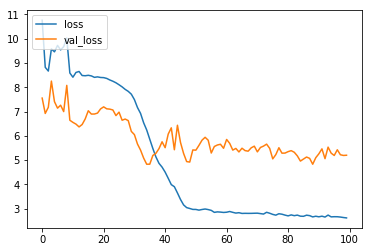

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["loss","val_loss"],loc="upper left")

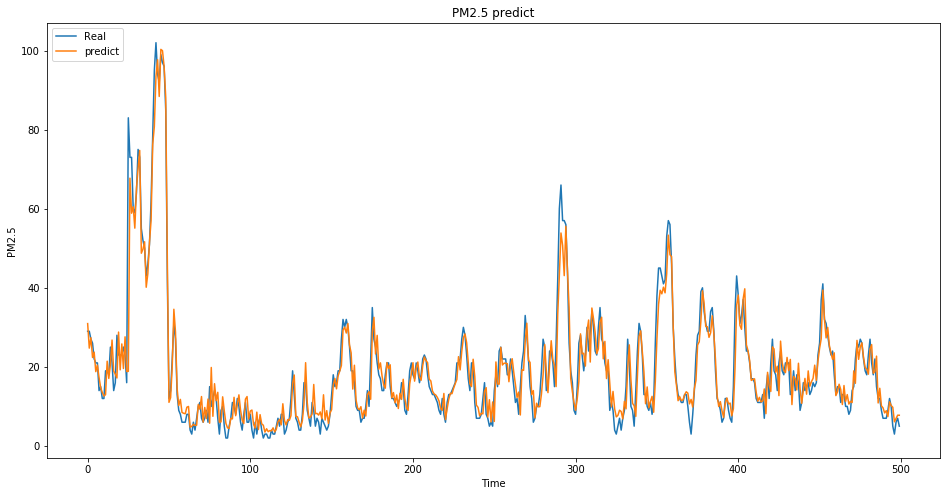

In [18]:
plt.figure(figsize=(16,8))
plt.plot(Y_train[0:500])
plt.plot(model.predict(X_train[0:500]))
plt.title("PM2.5 predict")

plt.ylabel("PM2.5")

plt.xlabel("Time")

plt.legend(["Real","predict"],loc="upper left")

plt.show()

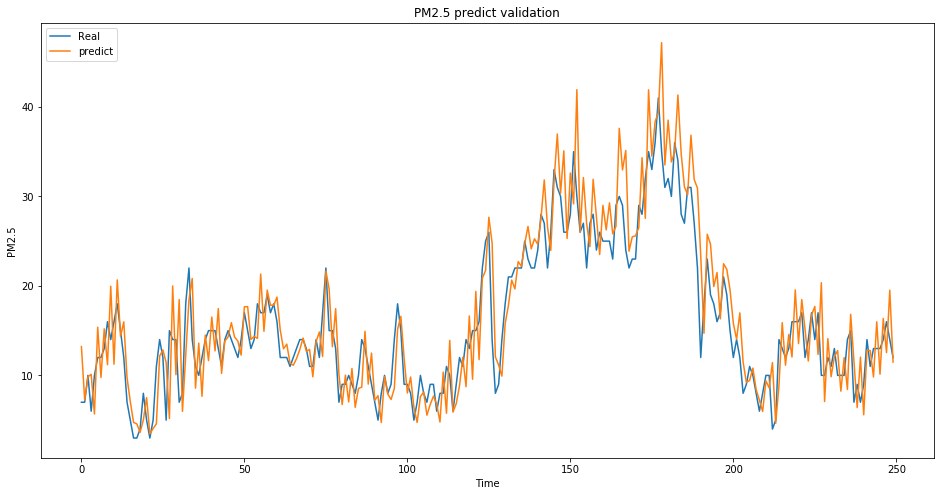

In [20]:
plt.figure(figsize=(16,8))
plt.plot(Y_test[0:250])
plt.plot(model.predict(X_test[0:250]))
plt.title("PM2.5 predict validation")

plt.ylabel("PM2.5")

plt.xlabel("Time")

plt.legend(["Real","predict"],loc="upper left")

plt.show()